In [1]:
from model import Transformer
from util import PointedIndex
from util_io import encode, decode
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
len_cap = 256
idx_src = PointedIndex(np.load("trial/data/index_src.npy").item())
idx_tgt = PointedIndex(np.load("trial/data/index_tgt.npy").item())

In [3]:
model = Transformer.new().data(len_cap= len_cap)
forcing = model.forcing(trainable= False) # teacher forcing mode
autoreg = model.autoreg(trainable= False) # autoregressive mode

In [4]:
saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver.restore(sess, "trial/model/m629820")

INFO:tensorflow:Restoring parameters from trial/model/m629820


In [5]:
# run the model in autoregressive mode

def auto(s, m= autoreg, idx_src= idx_src, idx_tgt= idx_tgt, len_cap= len_cap):
    # encode the sentence as a numpy array
    # it's automatically padded at the beginning and the end
    src = np.array(encode(idx_src, s))
    # reshape the array into a batch with one instance
    src.shape = 1, -1
    # fetch the prediction
    # tgt needs to be fed the first step (the padding at the beginning)
    # len_tgt is the maximum steps to unroll
    pred = m.pred.eval({m.src: src, m.tgt: src[:,:1], m.len_tgt: len_cap})
    # take the only instance from the batch
    pred = pred[0]
    # decode the prediction
    return decode(idx_tgt, pred)

# to run the forcing model, remember to feed a encoded target sentence
# and DON'T feed len_tgt
# cuz that's simply the length of the encoded target minus the beginning

In [6]:
auto("Sodium iodate ( NaIO3 ) is the sodium salt of iodic acid .")

'Sodium iodate is the sodium salt of iodic acid .'

In [7]:
# fake autoregressive with teacher forcing for visualization
# since some attention weight tensors in autoreg
# exist in loops and cannot be retrieved

g = tf.get_default_graph()
e1 = g.get_tensor_by_name("encode_forcing/layer1/att/attention/Reshape_1:0")
e2 = g.get_tensor_by_name("encode_forcing/layer2/att/attention/Reshape_1:0")
d1 = g.get_tensor_by_name("decode_forcing/layer1/csl/attention/Reshape_1:0")
d2 = g.get_tensor_by_name("decode_forcing/layer2/csl/attention/Reshape_1:0")
c1 = g.get_tensor_by_name("decode_forcing/layer1/att/attention/Reshape_1:0")
c2 = g.get_tensor_by_name("decode_forcing/layer2/att/attention/Reshape_1:0")

def run(s, m= forcing):
    src = np.array(encode(idx_src, s)).reshape(1, -1)
    tgt = i = src[:,:1]
    for _ in range(len_cap):
        p, ad1, ad2, ac1, ac2 = sess.run((m.pred, d1, d2, c1, c2), {m.src: src, m.tgt: tgt})
        if 1 == p[0][-1]: break
        tgt = np.concatenate((i, p), 1)
    ae1, ae2 = sess.run((e1, e2), {m.src: src})
    return p[0], ae1[0], ae2[0], ad1[0], ad2[0], ac1[0], ac2[0]

def viz(s):
    tgt, *att = run(s)
    print(decode(idx_tgt, tgt))
    plt.figure(figsize= (7, 11))
    for i, a in enumerate(att, 1):
        plt.subplot(3, 2, i)
        plt.imshow(a, cmap= 'gray')    

Sodium iodate is the sodium salt of iodic acid .


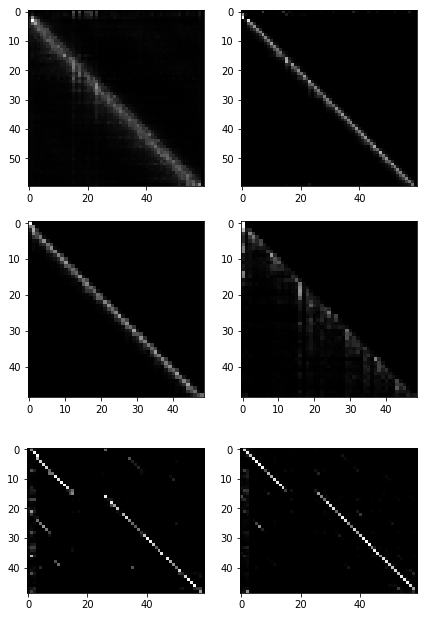

In [8]:
viz("Sodium iodate ( NaIO3 ) is the sodium salt of iodic acid .")

The enshrined kami is Isonotakeru no mikoto (      ? )


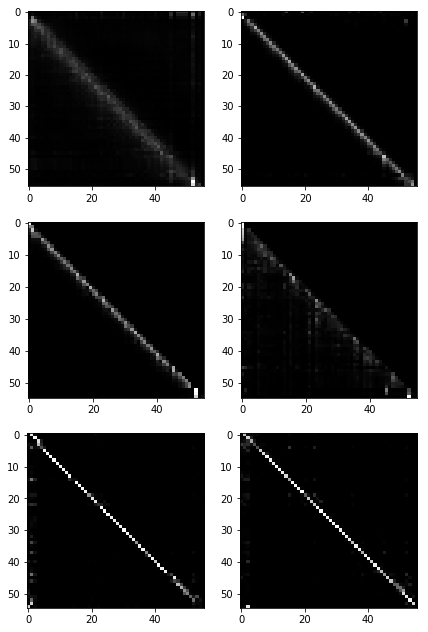

In [9]:
viz("The enshrined kami is Isonotakeru no mikoto ( 五十猛命 ? )")

Their first child , Prince George of Cambridge , was born on July 22 , 2013 .


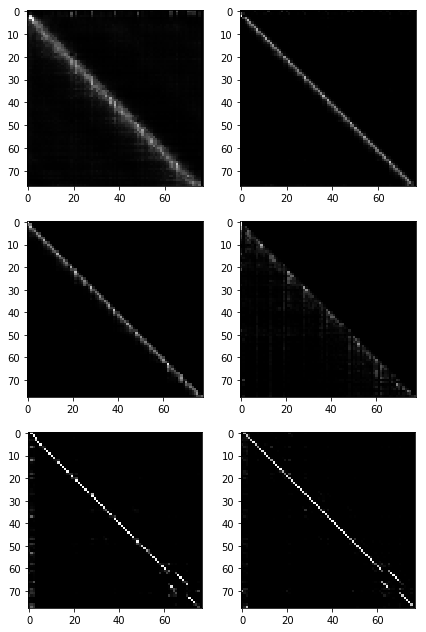

In [10]:
viz("Their first child , Prince George of Cambridge , was born on 22 July 2013 .")

For example , 2 + 3 = 3 = 3 = 3 = 3 = 3 = 3 = 3 , whereas 32 = 9 .


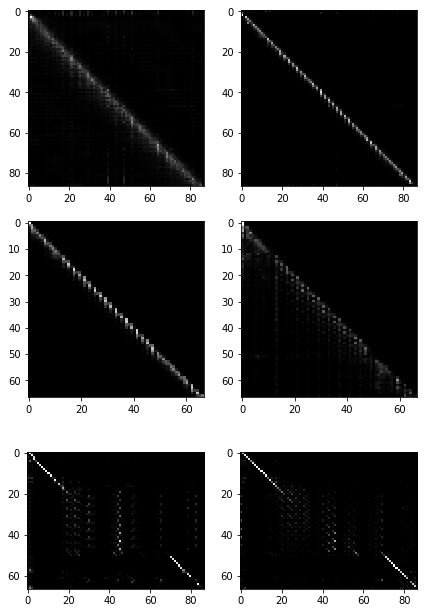

In [11]:
viz("For example , 2 + 3 = 3 + 2 = 5 and 2 · 3 = 3 · 2 = 6 , but 23 = 8 , whereas 32 = 9 .")

In the 19th century , the state of the state of the state of the state of the state of the state of the state .


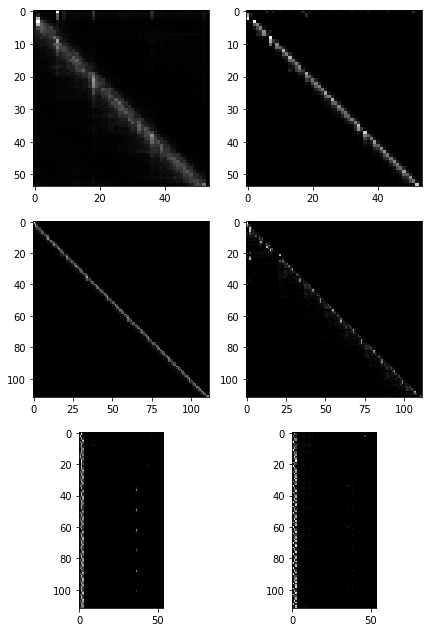

In [12]:
viz("1 and − 1 divide ( are divisors of ) every integer .")